<a href="https://colab.research.google.com/github/buoi/conditional-face-GAN/blob/main/attribute_conditional_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attribute Conditional Face Generation with GANs

Marco Buiani  
Matteo Folli

## Run Instructions

1. Select number of attributes and image size in **🎛 Notebook Inputs**
3. Select Runtime -> **Run All**  
4. Montor the training in **⏳ Train**


# 🎛 Notebook Inputs



In [21]:
# decides if the model is conditional or not
NUMBER_OF_ATTRIBUTES = "10" #@param [0, 2, 10, 40]
N_ATTRIBUTES = int(NUMBER_OF_ATTRIBUTES)

# shape of dataset input and model output
IMAGE_SHAPE = '218x178x3' #@param ['64x64x3', '218x178x3']
IMAGE_SHAPE = tuple(int(n) for n in IMAGE_SHAPE.split('x'))
IMAGE_SIZE = IMAGE_SHAPE[0]

ENABLE_SELF_ATTENTION = True #@param {type: 'boolean'}
BATCH_SIZE =   64#@param {type: "number"}
FID_COUNT = 10000
ENABLE_WANDB = False

# setting to a small int runs shorter epochs
TESTING_STEPS = 2

# image range for dataset and model, do not change
IMAGE_RANGE = '11'


# ⚙️ Setup

## Fix random seeds

In [22]:
SEED = 11
import os
os.environ['PYTHONHASHSEED']=str(SEED)
import random
import numpy as np
import tensorflow as tf

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Automatic Mixed Precision
if supported by GPU

In [23]:
_, gpu_name  = !nvidia-smi --query-gpu=gpu_name --format=csv

if gpu_name == 'Tesla T4':
    from tensorflow.keras import mixed_precision

    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0cb78319-a920-1673-2f33-d5f412eee954)


## Imports

In [24]:
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.layers import Layer, Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, Add, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, UpSampling2D, BatchNormalization
import tensorflow.keras.backend as K

from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization

import gdown
from zipfile import ZipFile

from tqdm.notebook import tqdm

## Download CelebA

We'll use face images from the CelebA dataset, resized to 64x64.

In [25]:
try:
    os.makedirs("celeba_gan")
    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "celeba_gan/img_align_celeba.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")
        
except FileExistsError:
    print("Dataset Already downloaded")


Dataset Already downloaded


In [26]:
#Download labels from public github, they have been processed in a 0,1 csv file
!wget -q -O "/content/celeba_gan/list_attr_celeba01.csv.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba01.csv.zip?raw=true" 
!unzip -o "/content/celeba_gan/list_attr_celeba01.csv.zip" -d "/content/celeba_gan"

Archive:  /content/celeba_gan/list_attr_celeba01.csv.zip
  inflating: /content/celeba_gan/list_attr_celeba01.csv  
  inflating: /content/celeba_gan/__MACOSX/._list_attr_celeba01.csv  


## Dataset preprocessing functions

In [27]:
# image utils functions

def conv_range(in_range=(-1,1), out_range=(0,255)):
    """ Returns range conversion function"""

    # compute means and spans once
    in_mean, out_mean = np.mean(in_range), np.mean(out_range)
    in_span, out_span = np.ptp(in_range), np.ptp(out_range)

    # return function
    def convert_img_range(in_img):
        out_img = (in_img - in_mean) / in_span
        out_img = out_img * out_span + out_mean
        return out_img

    return convert_img_range

def crop128(img):
    #return img[:, 77:141, 57:121]# 64,64 center crop
    return img[:, 45:173, 25:153] # 128,128 center crop

def resize64(img):
    return tf.image.resize(img, (64,64), antialias=True, method='bilinear')

# 💾  Build Dataset 
create Dataset object from our folder, and rescale the images to the [-1,1] range:

Found 202599 files belonging to 2 classes.
image in range:  -1.0 1.0


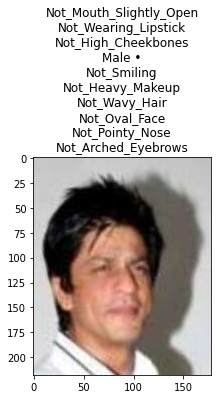

In [28]:
if N_ATTRIBUTES == 2:
    LABELS = ["Male", "Smiling"]

elif N_ATTRIBUTES == 10:
    LABELS = [
          "Mouth_Slightly_Open", "Wearing_Lipstick", "High_Cheekbones", "Male", "Smiling", 
          "Heavy_Makeup", "Wavy_Hair", "Oval_Face", "Pointy_Nose", "Arched_Eyebrows"]

elif N_ATTRIBUTES == 40:
    LABELS = [
            '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
            'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
            'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
            'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
            'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
            'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
            'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
            'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

else:
    LABELS = ["Male", "Smiling"]# just for dataset creation
 

# Take labels and a list of image locations in memory
df = pd.read_csv(r"/content/celeba_gan/list_attr_celeba01.csv")
im_list = df['image_id'].tolist()


# load image at exact resolution
dataset_train = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode="int", 
    labels = df[LABELS].values.tolist(),
    image_size=(218, 178), 
    batch_size=BATCH_SIZE,
    seed=SEED)


def preprocess(dataset):
    # extract the center crop
    if IMAGE_SIZE == 64:
        dataset = dataset.map(lambda x,y: (crop128(x),y) )
        # resize
        dataset = dataset.map(lambda x,y: (resize64(x),y) )
    # convert image range
    dataset = dataset.map(lambda x,y: (conv_range([0,255], [-1,1])(x),y) )
    return dataset

dataset_train = preprocess(dataset_train)

if N_ATTRIBUTES !=0: 
    batch_img, batch_labels = next(iter(dataset_train))
    plt.title('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*int(label) for i,label in enumerate(batch_labels[0])]))

else: # remove labels
    dataset_train = dataset_train.map(lambda x,y: x)
    batch_img = next(iter(dataset_train))
    
plt.imshow(batch_img[0].numpy()/2+0.5)

print("image in range: ", np.min(batch_img), np.max(batch_img))

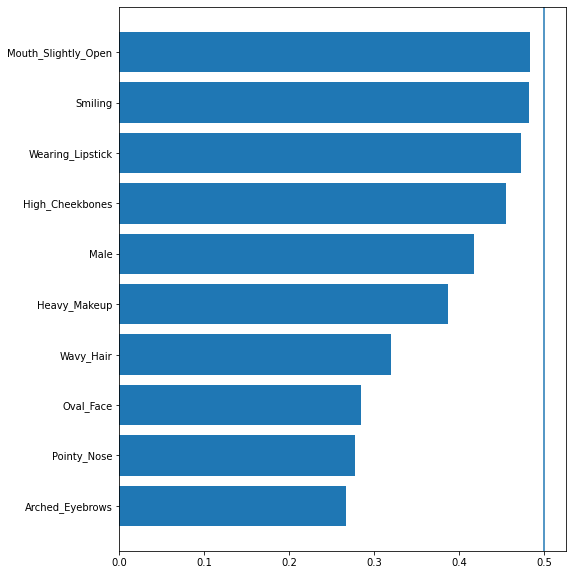

In [29]:
if N_ATTRIBUTES !=0:
    attribute_cumsums = np.sum(df[LABELS].values, axis=0)

    attribute_frequency = attribute_cumsums/df[LABELS].values.shape[0]
    # shows how much each attribute deviates from being 50%
    freq_sorted, labels_sorted  = zip(*sorted(zip(attribute_frequency, LABELS)))
    freq_sorted = np.array(freq_sorted)

    plt.figure(figsize=(8,10))
    plt.yticks(np.arange(N_ATTRIBUTES),labels=labels_sorted, fontsize=10)
    plt.axvline(x=0.5)
    plt.barh(np.arange(N_ATTRIBUTES), freq_sorted);

# 🕵🏻‍♂️👩🏼‍🎨 Model

## Custom Layers

### Spectral Normalization

In [30]:
from tensorflow_addons.layers import SpectralNormalization

### Self Attention

In [31]:
from keras.layers import InputSpec
import keras.backend as K

class SelfAttention(Layer):

    def __init__(self, ch, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f',
                                        trainable=True)
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g',
                                        trainable=True)
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h',
                                        trainable=True)

        super(SelfAttention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True

    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[3]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]

        s = K.batch_dot(hw_flatten(g), K.permute_dimensions(hw_flatten(f), (0, 2, 1)))  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

### Minibatch Standard Deviation

In [32]:
# mini-batch standard deviation layer
class MinibatchStdev(layers.Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # calculate the mean standard deviation across each pixel coord
    def call(self, inputs):
        mean = K.mean(inputs, axis=0, keepdims=True)
        mean_sq_diff = K.mean(K.square(inputs - mean), axis=0, keepdims=True) + 1e-8
        mean_pix = K.mean(K.sqrt(mean_sq_diff), keepdims=True)
        shape = K.shape(inputs)
        output = K.tile(mean_pix, [shape[0], shape[1], shape[2], 1])
        return K.concatenate([inputs, output], axis=-1)

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

## Define Building Functions

### BN stddev 218x178

In [33]:
# revisited
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
def define_generator218(latent_dim = 100, n_attributes=N_ATTRIBUTES):

    n_channels_large = 128

    z = keras.Input(shape=(latent_dim,))

    first_plane_shape = (7, 6, n_channels_large*8)

    gen_img = layers.Dense(np.prod(first_plane_shape),
                          kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(z)

    gen_img = layers.Reshape(first_plane_shape)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    #  attr input, dense,       reshape\
    #latent input, dense, relu, reshape/ concat, conv, BN

    if N_ATTRIBUTES !=0:
        in_attr = layers.Input(shape=(n_attributes))
        # attr -> 4*4
        attr_n_maps = {2:1, 10:1, 40:3}[N_ATTRIBUTES]
        attr_map = layers.Dense(np.prod(first_plane_shape[0]* first_plane_shape[1]*attr_n_maps),
                        kernel_initializer=RandomNormal(stddev=0.02,),
                        bias_initializer='zeros',)(in_attr)
                        
        attr_map = layers.Reshape((first_plane_shape[0], first_plane_shape[1], attr_n_maps))(attr_map)
        attr_map = layers.Activation('relu')(attr_map)

        #(None, 7,6, 1024) (None, 4,4,1)
        gen_img = layers.Concatenate()((gen_img, attr_map))


    # plane shape: (14,12,128*4)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*4, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)

    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (28,24,128*2)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*2, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)

    gen_img = layers.Activation('relu')(gen_img)

    if ENABLE_SELF_ATTENTION:
        gen_img = SelfAttention(n_channels_large*2)(gen_img)


    # plane shape: (56,48,128)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    # plane shape: (56,46,128)
    gen_img = tf.keras.layers.Cropping2D((0,1))(gen_img)

    # plane shape: (112,92,3)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (224,184,3)
    gen_img = Conv2DTranspose(filters=3, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same')(gen_img)
    
    # plane shape: (218,178,3)
    gen_img = tf.keras.layers.Cropping2D((3,3))(gen_img)

    gen_img = layers.Activation(activation='tanh', dtype='float32')(gen_img)

    if N_ATTRIBUTES !=0:
        generator = keras.Model(inputs= [z, in_attr], outputs=gen_img, name='cond_gen')
    else:
        generator = keras.Model(inputs=z, outputs=gen_img, name='gen')
    return generator
    return generator

def define_discriminator218(n_attributes=N_ATTRIBUTES):

    ndf = 128  # ndf or NDF: Number of Discriminator Filters

    input_img = layers.Input(shape=(218,178,3))

    # plane shape: (109,89,ndf)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(input_img)

    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (55,45,ndf*2)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (28,23,ndf*2)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    if ENABLE_SELF_ATTENTION:
        d_output_proba = SelfAttention(ndf*2)(d_output_proba)

    # plane shape: (14,12,ndf*4)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*4, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)
    

    # plane shape: (7,6,ndf*8)
    d_output_proba = Conv2D(filters=ndf*8, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    
    d_output_proba = MinibatchStdev()(d_output_proba)
    
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # Flatten and Dense to (None, 1) \in [0, 1].
    d_output_proba = layers.Flatten()(d_output_proba)

    out_realfake = layers.Dense(1,kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(d_output_proba)

    out_realfake = layers.Activation('sigmoid', name='sigmoid_realfake', dtype='float32')(out_realfake)

    if N_ATTRIBUTES !=0:
        out_attr = layers.Dense(n_attributes, dtype='float32')(d_output_proba)
        out_attr = layers.Activation('sigmoid', name='sigmoid_label', dtype='float32')(out_attr)
        discriminator = keras.Model(inputs=input_img, outputs=[out_realfake, out_attr], name='cond_discr')
    else:
        discriminator = keras.Model(inputs=input_img, outputs=out_realfake, name='discr')

    return discriminator



define_generator218().summary()
define_discriminator218().summary()


Model: "cond_gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 43008)        4343808     input_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 42)           462         input_8[0][0]                    
___________________________________________________________________________________________

### BN stddev 64x64

In [34]:
# revisited
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
def define_generator64(latent_dim = 100, n_attributes=N_ATTRIBUTES):

    n_channels_large = 128

    z = keras.Input(shape=(latent_dim,))
    first_plane_shape = (4, 4, n_channels_large*8)

    gen_img = layers.Dense(np.prod(first_plane_shape),
                          kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(z)

    gen_img = layers.Reshape(first_plane_shape)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)

    #  attr input, dense,       reshape\
    #latent input, dense, relu, reshape/ concat, conv, BN
    
    if N_ATTRIBUTES !=0:
        in_attr = layers.Input(shape=(n_attributes))
        # attr -> 4*4
        attr_n_maps = {2:1, 10:1, 40:3}[N_ATTRIBUTES]
        attr_map = layers.Dense(np.prod(first_plane_shape[0]* first_plane_shape[1]*attr_n_maps),
                        kernel_initializer=RandomNormal(stddev=0.02,),
                        bias_initializer='zeros',)(in_attr)
                        
        attr_map = layers.Reshape((first_plane_shape[0], first_plane_shape[1], attr_n_maps))(attr_map)
        attr_map = layers.Activation('relu')(attr_map)

        #(None, 4,4, 1024) (None, 4,4,1)
        gen_img = layers.Concatenate()((gen_img, attr_map))


    # plane shape: (8,8,128*4)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*4, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)

    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (16,16,128*2)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large*2, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    if ENABLE_SELF_ATTENTION:
        gen_img = SelfAttention(n_channels_large*2)(gen_img)


    # plane shape: (32,32,128)
    gen_img = SpectralNormalization(
        layers.Conv2DTranspose(filters=n_channels_large, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(gen_img)
    gen_img = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(gen_img)
    gen_img = layers.Activation('relu')(gen_img)


    # plane shape: (64,64,3)
    gen_img = Conv2DTranspose(filters=3, kernel_size=5,
                      kernel_initializer=RandomNormal(stddev=0.02,),
                      strides=2, padding='same')(gen_img)
    gen_img = layers.Activation(activation='tanh', dtype='float32')(gen_img)

    if N_ATTRIBUTES !=0:
        generator = keras.Model(inputs= [z, in_attr], outputs=gen_img, name='cond_gen')
    else:
        generator = keras.Model(inputs=z, outputs=gen_img, name='gen')
    return generator

def define_discriminator64(n_attributes=N_ATTRIBUTES):

    ndf = 128  # ndf or NDF: Number of Discriminator Filters

    input_img = layers.Input(shape=(64,64,3))

    #layers.RandomFlip(mode='horizontal')(input_img)

    # plane shape: (32,32,ndf)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(input_img)

    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    if ENABLE_SELF_ATTENTION:
        d_output_proba = SelfAttention(ndf)(d_output_proba)

    # plane shape: (16,16,ndf*2)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*2, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)


    # plane shape: (8,8,ndf*4)
    d_output_proba = SpectralNormalization(
        layers.Conv2D(filters=ndf*4, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same'), dtype='float32')(d_output_proba)
    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # plane shape: (4,4,ndf*8)
    d_output_proba = Conv2D(filters=ndf*8, kernel_size=5,
                      kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02,),
                      strides=2, padding='same')(d_output_proba)

    d_output_proba = layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-5)(d_output_proba)
    
    d_output_proba = MinibatchStdev()(d_output_proba)
    
    d_output_proba = layers.LeakyReLU(alpha=0.2)(d_output_proba)

    # Flatten and Dense to (None, 1) \in [0, 1].
    d_output_proba = layers.Flatten()(d_output_proba)

    out_realfake = layers.Dense(1,kernel_initializer=RandomNormal(stddev=0.02,),
                          bias_initializer='zeros',)(d_output_proba)

    out_realfake = layers.Activation('sigmoid', name='sigmoid_realfake', dtype='float32')(out_realfake)

    if N_ATTRIBUTES !=0:
        out_attr = layers.Dense(n_attributes, dtype='float32')(d_output_proba)
        out_attr = layers.Activation('sigmoid', name='sigmoid_label', dtype='float32')(out_attr)
        discriminator = keras.Model(inputs=input_img, outputs=[out_realfake, out_attr], name='cond_discr')
    else:
        discriminator = keras.Model(inputs=input_img, outputs=out_realfake, name='discr')

    return discriminator


define_generator64().summary()
define_discriminator64().summary()


Model: "cond_gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 16384)        1654784     input_10[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 16)           176         input_11[0][0]                   
___________________________________________________________________________________________

## Define GAN Class
override `train_step`

### AC-GAN

In [35]:
class ACGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, n_attributes, **kwargs):
        super(ACGAN, self).__init__(**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_attributes = n_attributes

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ACGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

        self.d_realfake_metric = keras.metrics.Mean(name="d_realfake")
        self.d_attr_metric = keras.metrics.Mean(name="d_attr")

        self.g_realfake_metric = keras.metrics.Mean(name="g_realfake")
        self.g_attr_metric = keras.metrics.Mean(name="g_attr")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_attr = data 

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator([random_latent_vectors, real_attr])
        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels_fake = tf.ones((batch_size, 1)) - 0.05 * tf.random.uniform((batch_size, 1))
        labels_real = tf.zeros((batch_size, 1)) + 0.05 * tf.random.uniform((batch_size, 1))
        labels_realfake = tf.concat([labels_fake, labels_real], axis=0)

        labels_attr = tf.concat([real_attr, real_attr], axis=0) #????
        labels_attr = tf.cast(labels_attr, dtype='float32')

        # Train the discriminator
        with tf.GradientTape() as tape:
            pred_realfake, pred_attr = self.discriminator(combined_images)
            pred_real_attr = pred_attr[batch_size: 2*batch_size]

            d_loss_realfake = self.loss_fn(labels_realfake, pred_realfake)

            d_loss_attr = self.loss_fn(real_attr, pred_real_attr)

            d_loss = d_loss_realfake + d_loss_attr 
      
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))


        random_latent_vectors = tf.random.normal(shape=(2*batch_size, self.latent_dim))
        misleading_labels = tf.zeros((2*batch_size, 1))

        with tf.GradientTape() as tape:
            pred_realfake, pred_attr = self.discriminator(
                self.generator([random_latent_vectors, labels_attr]))
            
            g_loss_realfake = self.loss_fn(misleading_labels, pred_realfake)
            g_loss_attr = self.loss_fn(labels_attr, pred_attr)
            g_loss = g_loss_realfake + g_loss_attr

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))



        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        self.d_realfake_metric.update_state(d_loss_realfake)
        self.d_attr_metric.update_state(d_loss_attr)

        self.g_realfake_metric.update_state(g_loss_realfake)
        self.g_attr_metric.update_state(g_loss_attr)
       
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),

            "d_loss_realfake": self.d_realfake_metric.result(),
            "d_loss_attr": self.d_attr_metric.result(),
            "g_loss_realfake": self.g_realfake_metric.result(),
            "g_loss_attr": self.g_attr_metric.result()
        }

    def call(self, inputs):
        latent, label = inputs
        generated_images = self.generator([latent, label])
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss


### GAN

In [36]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Add random noise to the labels without going outside 0-1 range
        labels_fake = tf.ones((batch_size, 1)) - 0.05 * tf.random.uniform((batch_size, 1))
        labels_real = tf.zeros((batch_size, 1)) + 0.05 * tf.random.uniform((batch_size, 1))

        labels = tf.concat([labels_fake, labels_real], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        generator_gain = 2
        random_latent_vectors = tf.random.normal(shape=(generator_gain*batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((generator_gain*batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs):
        
        generated_images = self.generator(inputs)
        d_loss = self.discriminator(generated_images)
        return generated_images, d_loss


# 📉 Training callbacks

### Images logger

In [37]:
class ImagesLogger(keras.callbacks.Callback):
    def __init__(self, num_img=8, latent_dim=100, batch_freq=200, **kwargs):
        super(ImagesLogger, self).__init__(**kwargs)
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.batch_freq = batch_freq
        print("logging images every",batch_freq,"batches")

    def log_images(self,log_wandb):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))

        if N_ATTRIBUTES !=0:
            random_attr = np.array([df[LABELS].values[i] for i in np.random.randint(0,202600, self.num_img)])
            generated_images = self.model.generator((random_latent_vectors, random_attr))
        else:
            generated_images = self.model.generator(random_latent_vectors)

        generated_images.numpy()
        if IMAGE_RANGE == '11':
            generated_images = conv_range((-1,1), (0,1))(generated_images)

        if log_wandb:
            log_images = [wandb.Image(img) for img in generated_images]
            #log_name = f"Epoch {str(epoch)+str(LABELS)+str(random_attr.numpy())}"
            wandb.log({f"Epoch {epoch}": (log_images)})

        fig, axes = plt.subplots(1, self.num_img, figsize=(30,30))
        
        for i, axis in enumerate(axes):
            axis.axis('off')
            if N_ATTRIBUTES !=0:
                axis.set_title('\n'.join([' ☑  '+label*' '.join(LABELS[i].split('_')) for i,label in enumerate(random_attr[i])]),loc='left',fontsize=15)
                #axis.title.set_text('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*label for i,label in enumerate(random_attr[i])]))
            axis.imshow(generated_images[i])
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        self.log_images(log_wandb = ENABLE_WANDB)
 
    def on_batch_end(self, batch, logs=None):
        '''plot images locally with desired batch frequency'''

        if self.batch_freq != 0:
            if (batch+1) % self.batch_freq == 0:
                self.log_images(log_wandb=False)


### Model logger

In [38]:
# log checkpoint artifacts to wandb

SAVE_PATH = 'models/'
os.makedirs(SAVE_PATH, exist_ok=True)

class ModelLogger(keras.callbacks.Callback):
    def __init__(self, model_name=None, run=None):
        super(ModelLogger, self).__init__()

        if ENABLE_WANDB:
            self.run = run
            self.model_name = model_name
        else:
            self.model_name = 'model'

        
        
    def on_epoch_end(self, epoch, logs=None):
        print("Saving model")

        self.model.save(SAVE_PATH + self.model_name, save_format='tf')
        if ENABLE_WANDB:
            self.artifact = wandb.Artifact(self.model_name, type='model')
            self.artifact.add_dir(SAVE_PATH)
            self.run.log_artifact(self.artifact)


### FID Logger

In [39]:
#@title Load Multilabel Classifier Model{form-width: "35%", display-mode: "both" }

def f1_metric_logits(y_true, y_pred):
    y_pred = K.round(keras.activations.sigmoid(y_pred))
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def weighted_bce_from_logits(y_true, y_pred):

    #inverted_frequency weighting
    pos_weight= (1-attribute_frequency)*2
    y_true = tf.cast(y_true,'float32')
    bce = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=pos_weight)
    #weighted_bce = attribute_frequency*(1-y_true) *bce
    #print(bce, weighted_bce)
    return K.mean(bce,axis=-1)


custom_objects = {'f1_metric_logits': f1_metric_logits,
                  'weighted_bce_from_logits': weighted_bce_from_logits}

if IMAGE_SIZE == 64:
    if N_ATTRIBUTES == 2:
        resume_id = "2ckbukxu"
        model_name = experiment_name = "mobilenet_2attr_weighted"
        
        keras_metadata_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDI1ODc=/54e0c2174d2d72b2aad99d6f3edb9478"
        saved_model_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDI1ODc=/c6ed38f84d49a73fcccc7cc3947d6976"
        variables_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDI1ODc=/169bada1896162b8600275781a507077"
        index_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDI1ODc=/014e7165dbc24bc0ed55e088bf56ff65"


    elif N_ATTRIBUTES == 10:
        resume_id = "1ciqd5nw"
        model_name = experiment_name = "mobilenet_10attr_weighted"

        keras_metadata_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDkwODM=/b0843a4e7f983e156eefda7e218fac84"
        saved_model_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDkwODM=/73898d1b00855e233b5eb9ad2f19edd6"
        variables_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDkwODM=/7ef193295b72d42e6990c66d0e44c98a" 
        index_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0NDkwODM=/2ef2d12ecc8f79f17d55d430a185b8d5"

    elif N_ATTRIBUTES == 40:
        resume_id = "123ijj97"
        model_name = experiment_name = "mobilenet_40attr_weighted"
        
        keras_metadata_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0MzU4NzY=/c2696523ad6bc0a5c3e80eaa528158a0"
        saved_model_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0MzU4NzY=/df7357b4fb17005995cd9c8ac37f1aa1"
        variables_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0MzU4NzY=/ed6bb693bb3789ebae0e79ec2d8331a4" 
        index_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI0MzU4NzY=/c72922c943050df965eff6484dbfc954"

    else:
        print("N_ATTRIBUTES=", N_ATTRIBUTES, "skipping classifier load")
        ENABLE_LOAD = False

elif IMAGE_SIZE == 218:
    if N_ATTRIBUTES == 2:
        resume_id = '3b15ld8p'
        model_name = experiment_name = "mobilenet_2attr_218x178_weighted"

        keras_metadata_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1NzgwNzE=/f68713bc74adac9c3d8b4aee9064f76a"
        saved_model_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1NzgwNzE=/65f63abdb95dbf59c398ab0a9314609b"
        variables_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1NzgwNzE=/b313ebd8a28edf7b9fcc291f5d350f83"
        index_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1NzgwNzE=/728b69786f7a1fd77cb0d6edb5b0b6d1"

    elif N_ATTRIBUTES == 10:
        resume_id = "3n56eda3"
        model_name = experiment_name = "mobilenet_10attr_218x178_weighted"

        keras_metadata_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTkyMTk=/55a5f2dfe27eeb1873e05e8b7a4be86a"
        saved_model_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTkyMTk=/a13318bc9a500bcde0cb020182dec064"
        variables_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTkyMTk=/69be9cba2020b21eeb4bcb6bbf887136"
        index_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTkyMTk=/65079a2e8655615837abbf7390aec2fc"

    elif N_ATTRIBUTES == 40:
        resume_id = "zd9xh3kq"
        model_name = experiment_name = "mobilenet_40attr_218x178_weighted"

        keras_metadata_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTAyMjU=/58e2dc40dc2afb2ac5c771acc1d2dd78"
        saved_model_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTAyMjU=/22cb81a3b8ec24619f8204d383849c81"
        variables_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTAyMjU=/c80537ac89fa927fd68bcb6cd752a8a6"
        index_url = "https://api.wandb.ai/artifactsV2/gcp-us/buio/QXJ0aWZhY3Q6MzI1OTAyMjU=/79ec8ead744b1bc4e19c098de9ff0f22"

    else:
        print("N_ATTRIBUTES=", N_ATTRIBUTES, "skipping classifier load")
        ENABLE_LOAD = False


if N_ATTRIBUTES !=0 :
    if ENABLE_WANDB:
        # load classifier artifact
        project_name = "GAN"
        !pip install wandb > /dev/null
        !wandb login
        import wandb
        from wandb.keras import WandbCallback
        run = wandb.init(project=project_name, 
                        name=experiment_name, 
                        resume=resume_id)

        run_name = 'buio/GAN/'+ model_name
        artifact_run = run_name +':latest'

        artifact = run.use_artifact(artifact_run, type='model')
        artifact_dir = artifact.download()
        attribute_classifier = tf.keras.models.load_model(os.path.join(artifact_dir, model_name),
                                                        custom_objects=custom_objects)

        attribute_classifier.compile(loss=keras.losses.BinaryCrossentropy(), metrics='binary_accuracy')
        #loss, gen_attr_accuracy = attribute_classifier.evaluate(dataset_df)
        #gen_attr_accuracy
        run.finish()

    else:
        #avoid wandb login with wget
        attr_cls_path = "/content/attribute_classifier_model/"
        try:
            os.remove(attr_cls_path+"keras_metadata.pb")
            os.remove(attr_cls_path+"saved_model.pb")
            os.remove(attr_cls_path+"variables/variables.data-00000-of-00001")
            os.remove(attr_cls_path+"variables/variables.index")
        except FileNotFoundError:
            pass
            
        os.makedirs(attr_cls_path,exist_ok =True)
        os.makedirs(attr_cls_path+"/variables",exist_ok =True)
        

        !pip install wget
        import wget
        wget.download(keras_metadata_url, attr_cls_path+"keras_metadata.pb")
        wget.download(saved_model_url, attr_cls_path+"saved_model.pb")
        wget.download(variables_url, attr_cls_path+"variables/variables.data-00000-of-00001")
        wget.download(index_url, attr_cls_path+"variables/variables.index")

        attribute_classifier = tf.keras.models.load_model(attr_cls_path,custom_objects=custom_objects)
        attribute_classifier.compile(loss=keras.losses.BinaryCrossentropy(), metrics='binary_accuracy')

    attribute_classifier.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 218, 178, 3)]     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 1280)              0         
_________________________________________________________________
classifier (Dense)           (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________


In [40]:
class FIDLogger(keras.callbacks.Callback):
    def __init__(self, real_embeddings, real_attr=None):
        super(FIDLogger, self).__init__()
        self.real_embeddings = real_embeddings
        self.real_attr = real_attr

    def on_epoch_end(self, epoch, logs=None): # end
        print("Computing Metrics")

        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

        if N_ATTRIBUTES !=0:
            multi_evaluator = define_evaluator(self.model.generator, attribute_classifier)
        else:
            multi_evaluator = define_evaluator(self.model.generator)

        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
        
        gen_size = 100
        assert FID_COUNT % gen_size == 0

        generated_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')

        if N_ATTRIBUTES !=0:
            pred_attr = np.zeros((FID_COUNT, N_ATTRIBUTES), dtype='float32')

            for i in tqdm(range(FID_COUNT//gen_size)):
              
                batch_embeddings, batch_attr = multi_evaluator((
                    tf.random.normal([gen_size, LATENT_DIM]),
                    self.real_attr[i*gen_size:(i+1)*gen_size]))
                
                generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings
                pred_attr[i*gen_size:(i+1)*gen_size] = batch_attr

            acc = np.mean(tf.keras.metrics.binary_accuracy(self.real_attr, pred_attr))
            f1_score = f1_metric_logits(self.real_attr, pred_attr).numpy()

        else:
            for i in tqdm(range(FID_COUNT//gen_size)):
              
                batch_embeddings = multi_evaluator(tf.random.normal([gen_size, LATENT_DIM]))
                
                generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings

        fid = compute_fid(self.real_embeddings, generated_embeddings)

        if N_ATTRIBUTES !=0:
            print("FID:",fid, "attribute accuracy:", acc, "f1-score:", f1_score)
        else:
            print("FID:",fid)

        if ENABLE_WANDB:
            wandb.log({'FID': fid})
            if N_ATTRIBUTES !=0:
                wandb.log({'attr_acc': acc})
                wandb.log({'attr_f1_score': f1_score})

def define_evaluator(generator, attr_classifier=None):
    
    img = generator.output
    img = tf.cast(img, tf.float32)

    if IMAGE_RANGE == '01':
        img = img*2 -1

    img_up299 = tf.image.resize(img, (299, 299), method='bilinear', antialias=True, name='upsample_bilinear')
    output_repr = inception_model(img_up299)

    if N_ATTRIBUTES !=0:
        attributes = attr_classifier(img) # mobilenet model does resizing.. does *2-1 also...
        multi_evaluator = tf.keras.Model(inputs=generator.inputs, outputs=[output_repr, attributes])
    else:
        multi_evaluator = tf.keras.Model(inputs=generator.inputs, outputs=output_repr)

    return multi_evaluator

def compute_fid(real_embeddings, generated_embeddings):
    # compute mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
    # compute sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
      covmean = covmean.real
    # compute fid score
    trace = np.trace(sigma1 + sigma2 - 2.0 * covmean)
    fid = ssdiff + trace
    print("fid:",fid,"ssdiff:",ssdiff, "trace:",trace)
    return fid

### Precompute FID embeddings

In [41]:
#fid
inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg',
                              input_shape=(299, 299, 3))


def define_real_prep():

    img = layers.Input(shape=IMAGE_SHAPE, name='img_input')
    img_up = tf.image.resize(img, (299, 299), method='bilinear', antialias=True, name='upsample_bilinear')
    if IMAGE_RANGE == '01':
        img_up = img_up*2 -1

    output = inception_model(img_up)

    real_prep = tf.keras.Model(inputs=[img], outputs=[output])

    return real_prep

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
real_prep = define_real_prep()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

fid_bs = 200
assert FID_COUNT % fid_bs == 0

dataset_fid = dataset_train.unbatch().batch(fid_bs)

real_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')
if N_ATTRIBUTES !=0:
    real_attr = np.zeros((FID_COUNT, N_ATTRIBUTES), dtype='float32')

print("Computing embeddings for real images")
for i in tqdm(range(FID_COUNT//fid_bs)):
    if N_ATTRIBUTES !=0:
        batch_img, batch_attr = next(iter(dataset_fid))
        real_attr[i*fid_bs:(i+1)*fid_bs] = batch_attr
    else:
        batch_img = next(iter(dataset_fid))
    batch_embeddings = real_prep(batch_img)
    real_embeddings[i*fid_bs:(i+1)*fid_bs] = batch_embeddings


87924736/87910968 [==============================] - 1s 0us/step
Computing embeddings for real images


  0%|          | 0/50 [00:00<?, ?it/s]

# 🎚 Training Configuration

In [42]:
ADAM_LR_D = 0.00005
ADAM_LR_G = 0.00005
ADAM_B1 = 0.5
ADAM_B2 = 0.999

ENABLE_WANDB = False #@param {type:"boolean"}
WANDB_RESUME = False #@param {type:"boolean"}

resume_id = "h0hgqpg9" #@param {type: "string"}
WANDB_RESUME = (resume_id if WANDB_RESUME else False)

entity = 'buio'
project_name = "GAN" #@param {type: "string"}
model_name = "dcgan" #@param {type: "string"}
experiment_name = "dcgan" #@param {type: "string"}
run_notes = "" #@param {type: "string"}

assert '-' not in model_name
assert ' ' not in model_name

from keras.callbacks import ModelCheckpoint
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     entity = entity,
                     name=experiment_name, 
                     resume=WANDB_RESUME,
                     save_code=True)
    if run_notes:
        wandb.notes = run_notes
    wandb.config.batch_size = BATCH_SIZE
    wandb.config.adam_lr_d = ADAM_LR_D
    wandb.config.adam_lr_g = ADAM_LR_G
    wandb.config.adam_b1 = ADAM_B1
    wandb.config.adam_b2 = ADAM_B2
    wandb.config.img_range = IMAGE_RANGE
    wandb.config.n_attributes = N_ATTRIBUTES

## Build the Model

(1, 218, 178, 3) -0.0846359 0.054663464


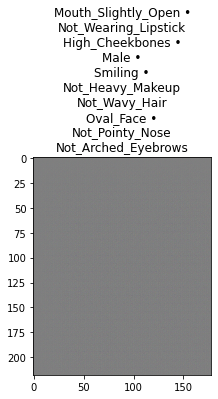

In [43]:
LATENT_DIM = 100

if IMAGE_SHAPE == (64,64,3):
    discriminator = define_discriminator64(n_attributes=N_ATTRIBUTES)
    generator = define_generator64(latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)
elif IMAGE_SHAPE == (218,178,3):
    discriminator = define_discriminator218(n_attributes=N_ATTRIBUTES)
    generator = define_generator218(latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)
 

if N_ATTRIBUTES !=0:
    # Build ACGAN
    gan = ACGAN(discriminator, generator, latent_dim=LATENT_DIM, n_attributes=N_ATTRIBUTES)
else:
    # Build GAN
    gan = GAN(discriminator, generator, latent_dim=LATENT_DIM)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR_D, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    g_optimizer=keras.optimizers.Adam(learning_rate=ADAM_LR_G, beta_1=ADAM_B1, beta_2 = ADAM_B2),
    loss_fn=keras.losses.BinaryCrossentropy()
)

# build model for saving

random_latent_vectors = tf.random.normal(shape=(1, LATENT_DIM))
if N_ATTRIBUTES !=0:
    random_attr = np.array([df[LABELS].values[i] for i in np.random.randint(0,202600, 1)])
    #random_attr = np.zeros((1,N_ATTRIBUTES))

    images, d_loss = gan.predict((random_latent_vectors, random_attr))

    plt.title('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*label for i,label in enumerate(random_attr[0])]))
else:
    images, d_loss = gan.predict(random_latent_vectors)

print(images.shape, np.min(images), np.max(images))
plt.imshow(images[0]/2+0.5)
#gan.save('models/'+model_name+experiment_name, save_format='tf')
resume_epoch = 0

In [44]:
if WANDB_RESUME:
    run_name = entity+'/GAN/'+ model_name + experiment_name
    artifact_run = run_name +':latest'

    artifact = run.use_artifact(artifact_run, type='model')
    artifact_dir = artifact.download()
    gan.load_weights(os.path.join(artifact_dir, model_name + experiment_name))
    resume_epoch = int(artifact_dir.split(':v')[-1]) +1
else:
    resume_epoch = 0

resume_epoch

0

# ⏳ Train

logging images every 200 batches
Epoch 1/60
2/2 [==============================] - 108s 908ms/step - d_loss: 1.2478 - g_loss: 1.3665 - d_loss_realfake: 0.5956 - d_loss_attr: 0.6910 - g_loss_realfake: 0.6756 - g_loss_attr: 0.6927


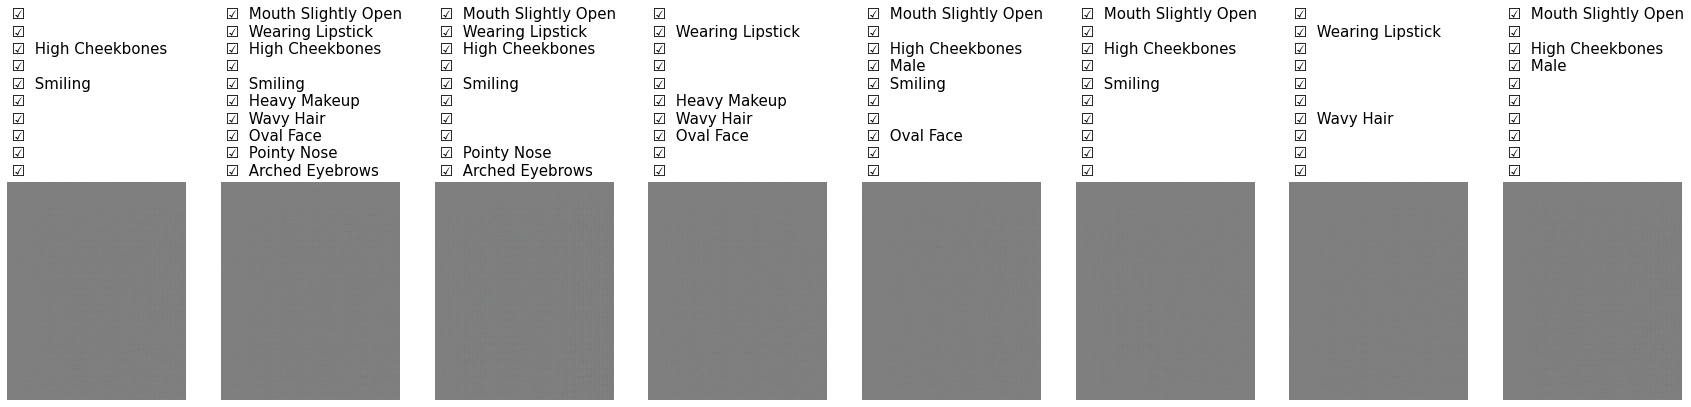

Saving model


Computing Metrics


  0%|          | 0/100 [00:00<?, ?it/s]

fid: 443.46861877667425 ssdiff: 310.01398 trace: 133.45464172589297
FID: 443.46861877667425 attribute accuracy: 0.6001399 f1-score: 0.0
Epoch 2/60
2/2 [==============================] - 2s 906ms/step - d_loss: 1.1044 - g_loss: 1.3614 - d_loss_realfake: 0.5024 - d_loss_attr: 0.6816 - g_loss_realfake: 0.6716 - g_loss_attr: 0.6924


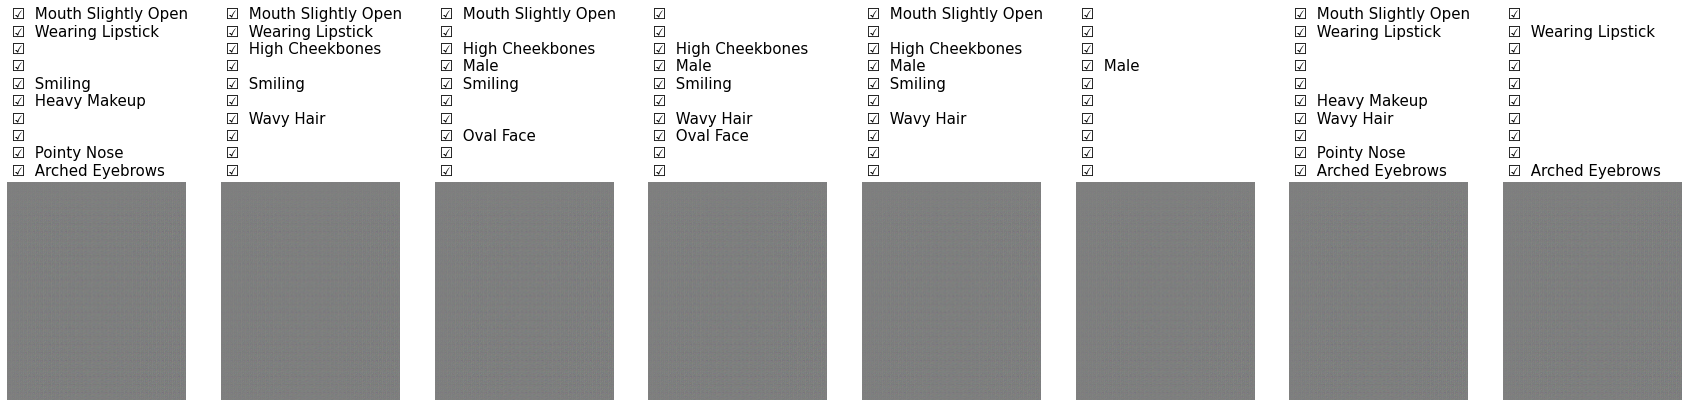

Saving model


In [ ]:
epochs = 60 

callbacks = [
    ImagesLogger(num_img=8, latent_dim=LATENT_DIM, batch_freq=200)]

if ENABLE_WANDB:
    callbacks.append(WandbCallback(log_batch_frequency=10, verbose=1),
    ModelLogger(model_name+experiment_name, run=run))
else:
    callbacks.append(ModelLogger())

if N_ATTRIBUTES !=0:
    callbacks.append(FIDLogger(real_embeddings, real_attr))
else:
    callbacks.append(FIDLogger(real_embeddings))


history = gan.fit(dataset_train, epochs=epochs,
        initial_epoch=resume_epoch, 
        steps_per_epoch=TESTING_STEPS,
        callbacks = callbacks
)
